In [73]:
#imprt libraries
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import json
import tifffile

In [74]:
#OAuth credentials for data acces
with open("log.json") as e:
    data = json.load(e);

CLIENT_ID = data["client_id"]
CLIENT_SECRET = data["client_secret"]

#for testin purposes
#print(CLIENT_ID)
#print(CLIENT_SECRET)

In [75]:
#set up user credentials 
client = BackendApplicationClient(client_id = CLIENT_ID)
oauth = OAuth2Session(client=client)

#acquire oatuh token for data acces
token = oauth.fetch_token(
    token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret = CLIENT_SECRET,
    include_client_id = True
)

In [76]:
#define image parameters
bbox = [28.846,46.446 , 27.886,45.486]
start_date = "2020-06-01"
end_date = "2020-08-31"
collection_id = "sentinel-2-l2a"

$NDVI = \frac{NIR - Red}{NIR + Red}, \quad NDWI = \frac{Green - NIR}{Green + NIR}$
$MNDWI = \frac{Green - SWIR}{Green + SWIR}, \quad NDBI = \frac{SWIR - NIR}{SWIR + NIR}$

**Sentinel-2 Bands:** $Green=B3, \ Red=B4, \ NIR=B8, \ SWIR=B11$

In [77]:
evalscript = """
function setup() {
  return {
    input: ["B03", "B04", "B08", "B11"],
    output: { 
      bands: 5, 
      sampleType: "FLOAT32" 
    }
  };
}

function evaluatePixel(sample) {
  let ndvi = index(sample.B08, sample.B04); 
  let ndwi = index(sample.B03, sample.B08); 
  let ndmi = index(sample.B08, sample.B11); 
  let ndbi = index(sample.B11, sample.B08);
  let mndwi = index(sample.B03, sample.B11);

  return [ndvi, ndwi, ndmi, ndbi, mndwi];
}
"""

In [78]:
json_request = {
    'input': {
        'bounds': {
            'bbox': bbox,
            'properties': { 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84' }
        },
        'data': [
            {
                'type': 'S2L2A',
                'dataFilter': {
                    'timeRange': {
                        'from': f'{start_date}T00:00:00Z',
                        'to': f'{end_date}T23:59:59Z'
                    },
                    'mosaickingOrder': 'leastCC',
                },
            }
        ]
    },
    'output': {
        'width': 1024,
        'height': 1024,
        'responses': [
            {
                'identifier': 'default',
                'format': { 'type': 'image/tiff' }
            }
        ]
    },
    'evalscript': evalscript
}

In [79]:
#send request
url_request = "https://sh.dataspace.copernicus.eu/api/v1/process"
headers_request = {
    "Authorization": f"Bearer {token['access_token']}"
}

response = oauth.post(url_request, headers=headers_request, json=json_request)
print("Sending request to Copernicus API...")

#debug request errors
if response.status_code == 200:
    print("Request successful.")
else:
    print(f"Error: {response.text}")

Sending request to Copernicus API...
Request successful.


Original Data Shape: (1024, 1024, 5)
Transposed Data Shape: (5, 1024, 1024)
--------------------
NDVI Mean:  0.3394
NDWI Mean:  -0.4138
NDMI Mean:  -0.1357
NDBI Mean:  0.1357
MNDWI Mean: -0.5263
--------------------


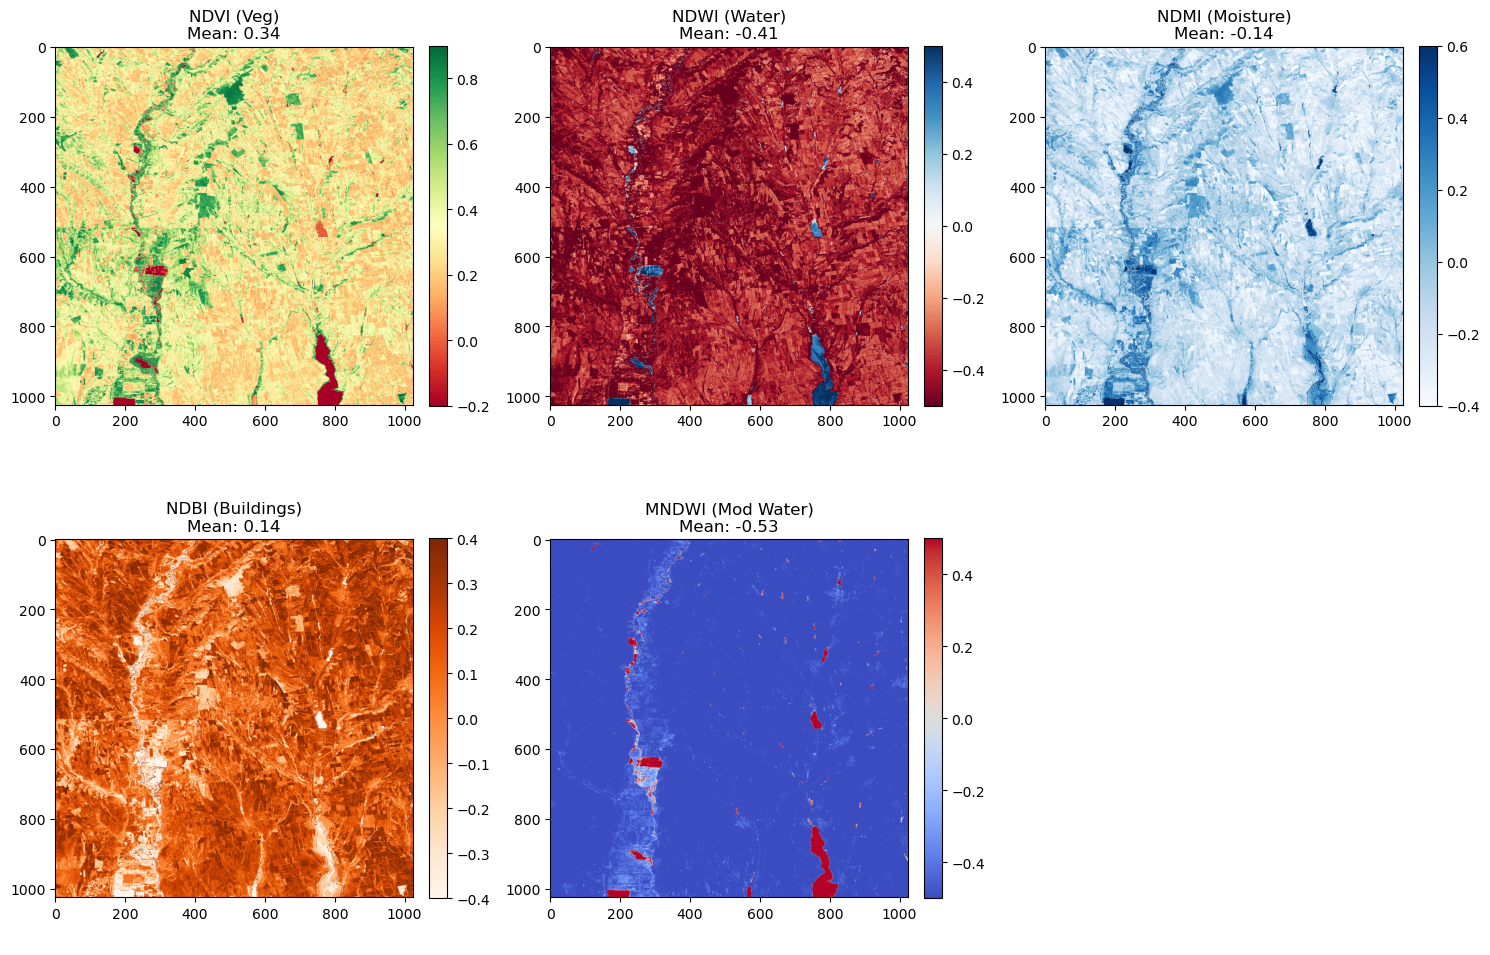

In [80]:
try:
    if 'response' in locals() and response.status_code != 200:
        raise ValueError(f"API Error: {response.text}")
    elif 'response' not in locals():
        print("Warning: 'response' variable not found. Using mock data for demonstration if needed.")

    image_arr = tifffile.imread(io.BytesIO(response.content))
    print(f"Original Data Shape: {image_arr.shape}") 

    if image_arr.ndim == 3 and image_arr.shape[2] <= 10 and image_arr.shape[0] > 10:
        image_arr = np.moveaxis(image_arr, -1, 0)
        print(f"Transposed Data Shape: {image_arr.shape}")

    if image_arr.shape[0] < 5:
        raise ValueError(f"Expected at least 5 bands (NDVI, NDWI, NDMI, NDBI, MNDWI), but got {image_arr.shape[0]}")

    ndvi_layer = image_arr[0].astype(float)
    ndwi_layer = image_arr[1].astype(float)
    ndmi_layer = image_arr[2].astype(float)
    ndbi_layer = image_arr[3].astype(float)
    mndwi_layer = image_arr[4].astype(float)

    def clean_layer(layer):
        layer = layer.copy() 
        mask = (layer < -1.0) | (layer > 1.0)
        layer[mask] = np.nan
        return layer

    ndvi_clean = clean_layer(ndvi_layer)
    ndwi_clean = clean_layer(ndwi_layer)
    ndmi_clean = clean_layer(ndmi_layer)
    ndbi_clean = clean_layer(ndbi_layer)
    mndwi_clean = clean_layer(mndwi_layer)

    print("-" * 20)
    print(f"NDVI Mean:  {np.nanmean(ndvi_clean):.4f}")
    print(f"NDWI Mean:  {np.nanmean(ndwi_clean):.4f}")
    print(f"NDMI Mean:  {np.nanmean(ndmi_clean):.4f}")
    print(f"NDBI Mean:  {np.nanmean(ndbi_clean):.4f}")
    print(f"MNDWI Mean: {np.nanmean(mndwi_clean):.4f}")
    print("-" * 20)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ax = axes.flatten()

    im1 = ax[0].imshow(ndvi_clean, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
    ax[0].set_title(f"NDVI (Veg)\nMean: {np.nanmean(ndvi_clean):.2f}")
    plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)

    im2 = ax[1].imshow(ndwi_clean, cmap='RdBu', vmin=-0.5, vmax=0.5)
    ax[1].set_title(f"NDWI (Water)\nMean: {np.nanmean(ndwi_clean):.2f}")
    plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

    im3 = ax[2].imshow(ndmi_clean, cmap='Blues', vmin=-0.4, vmax=0.6)
    ax[2].set_title(f"NDMI (Moisture)\nMean: {np.nanmean(ndmi_clean):.2f}")
    plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

    im4 = ax[3].imshow(ndbi_clean, cmap='Oranges', vmin=-0.4, vmax=0.4)
    ax[3].set_title(f"NDBI (Buildings)\nMean: {np.nanmean(ndbi_clean):.2f}")
    plt.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

    im5 = ax[4].imshow(mndwi_clean, cmap='coolwarm', vmin=-0.5, vmax=0.5)
    ax[4].set_title(f"MNDWI (Mod Water)\nMean: {np.nanmean(mndwi_clean):.2f}")
    plt.colorbar(im5, ax=ax[4], fraction=0.046, pad=0.04)

    ax[5].axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Processing failed: {e}")